In [ ]:
# outcome probability model for fastballs

In [120]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mysql.connector
import pybaseball
from sklearn.metrics import accuracy_score, confusion_matrix

In [273]:
# load in 2022 mlb season data

df = pd.read_csv(r'C:\Users\adam.bloebaum\.vscode\driveline\2022_MLB_Season.csv')

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"C:\Users\adam.bloebaum\.vscode\driveline\2023_MLB_Season.csv")

In [274]:
linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [275]:
xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_x_predictions.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_z_predictions.csv")
xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_spin_axis_predictions.csv")

In [276]:
print(xpfx_x.columns)
print(xpfx_z.columns)
print(xspin_axis.columns)

Index(['pitch_id_raw', 'pfx_x_cor', 'pfx_x_cor_predicted', 'pfx_x_cor_diff',
       'pfx_x_cor_diff_abs'],
      dtype='object')
Index(['pitch_id_raw', 'pfx_z', 'pfx_z_predicted', 'pfx_z_diff',
       'pfx_z_diff_abs'],
      dtype='object')
Index(['pitch_id_raw', 'spin_axis', 'spin_axis_predicted', 'spin_axis_diff',
       'spin_axis_diff_abs', 'arm_slot', 'height_ratio'],
      dtype='object')


In [277]:
# Clayton rerun with correct filename

xpfx_z.rename(columns={'pfx_z': 'pfx_z_cor'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_predicted': 'pfx_z_cor_predicted'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_diff': 'pfx_z_cor_diff'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_diff_abs': 'pfx_z_cor_diff_abs'}, inplace=True)

xspin_axis.rename(columns={'spin_axis': 'spin_axis_cor'}, inplace=True)

In [278]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs

df = df[df['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df['spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [279]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only fastballs

df_2023 = df_2023[df_2023['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df_2023['spin_axis'] = 360 - df['spin_axis']

# total movement column

df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column

df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [280]:
print(linear_weights)
print(df['description'].unique())
print(df['events'].unique())

    Unnamed: 0         description  linear_weight
0            0                ball       0.046350
1            1  caught_stealing_2b      -0.246377
2            2              double       0.753249
3            3         double_play      -0.773110
4            4           field_out      -0.217943
5            5                foul      -0.037243
6            6            home_run       1.368162
7            7              single       0.467429
8            8              strike      -0.052630
9            9           strikeout      -0.215231
10          10              triple       1.097815
11          11                walk       0.236323
['ball' 'called_strike' 'foul' 'hit_into_play' 'swinging_strike'
 'foul_tip' 'hit_by_pitch' 'blocked_ball' 'missed_bunt' 'foul_bunt'
 'swinging_strike_blocked' 'bunt_foul_tip']
[nan 'field_out' 'double' 'single' 'walk' 'strikeout' 'hit_by_pitch'
 'home_run' 'force_out' 'caught_stealing_2b' 'grounded_into_double_play'
 'sac_fly' 'field_error' 'doubl

In [281]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    #'hit_into_play': 'hit_into_play',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [282]:
def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# Apply the function to each row
df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [283]:
print(df['outcome'].unique())
print(df_2023['outcome'].unique())
print(df.shape)
print(df_2023.shape)

['ball' 'strike' 'foul' 'field_out' 'double' 'single' 'walk' 'strikeout'
 'home_run' 'double_play' nan 'triple']
['strike' 'foul' 'ball' 'single' 'double_play' 'field_out' 'strikeout'
 'home_run' 'double' 'walk' 'triple' nan]
(410504, 98)
(405495, 98)


In [284]:
df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [285]:
print(df['outcome'].unique())
print(df_2023['outcome'].unique())
print(df.shape)
print(df_2023.shape)

['ball' 'strike' 'foul' 'field_out' 'double' 'single' 'walk' 'strikeout'
 'home_run' 'double_play' 'triple']
['strike' 'foul' 'ball' 'single' 'double_play' 'field_out' 'strikeout'
 'home_run' 'double' 'walk' 'triple']
(409730, 98)
(404804, 98)


In [286]:
outcome_encoder = LabelEncoder()

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [287]:
print(df['outcome'].unique())
print(df_2023['outcome'].unique())
print(df.shape)
print(df_2023.shape)

[ 0  7  4  3  1  6 10  8  5  2  9]
[ 7  4  0  6  2  3  8  5  1 10  9]
(409730, 98)
(404804, 98)


In [288]:
# Perform the left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')

# Perform the left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')

In [289]:
# feature selection and data splitting

features = ['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio', 'pfx_x_cor', 'pfx_x_cor_predicted', 'pfx_x_cor_diff', 'pfx_x_cor_diff_abs', 'pfx_z_cor', 'pfx_z_cor_predicted', 'pfx_z_cor_diff_abs', 'spin_axis_cor', 'spin_axis_predicted', 'spin_axis_diff', 'spin_axis_diff_abs', 'arm_slot', 'height_ratio']

# copy and keep only features

df_2023_features = df_2023[features]

# create features and targets

X = df[features]
y = df['outcome']

# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [290]:
print(X_train.columns)

Index(['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'release_extension', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
       'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio', 'pfx_x_cor',
       'pfx_x_cor_predicted', 'pfx_x_cor_diff', 'pfx_x_cor_diff_abs',
       'pfx_z_cor', 'pfx_z_cor_predicted', 'pfx_z_cor_diff_abs',
       'spin_axis_cor', 'spin_axis_predicted', 'spin_axis_diff',
       'spin_axis_diff_abs', 'arm_slot', 'height_ratio'],
      dtype='object')


In [291]:
# set up model

model = xgb.XGBClassifier(objective='multi:softmax', num_class=11, eval_metric='mlogloss', use_label_encoder=False)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=11, num_parallel_tree=None, objective='multi:softmax', ...)

In [292]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.30520098601518075
Confusion Matrix:
[[23210     0     1    34   577     0     1  1371    23     0     3]
 [  907     0     0     0    29     0     0    56     0     0     0]
 [  418     0     0     1     4     0     0    34     1     0     0]
 [ 8519     0     0    17   257     0     2   578     4     0     1]
 [15905     0     0    22   510     0     0   946    14     0     0]
 [  613     0     0     1    11     0     0    26     0     0     0]
 [ 3025     0     0     4    68     0     1   190     1     0     0]
 [16525     0     0    19   507     1     1  1267     8     0     0]
 [ 3531     0     0     5   146     0     0   218     5     0     1]
 [   66     0     0     0     1     0     0     3     0     0     0]
 [ 2096     0     0     4    53     0     0   103     1     0     0]]


<Figure size 1000x5000 with 0 Axes>

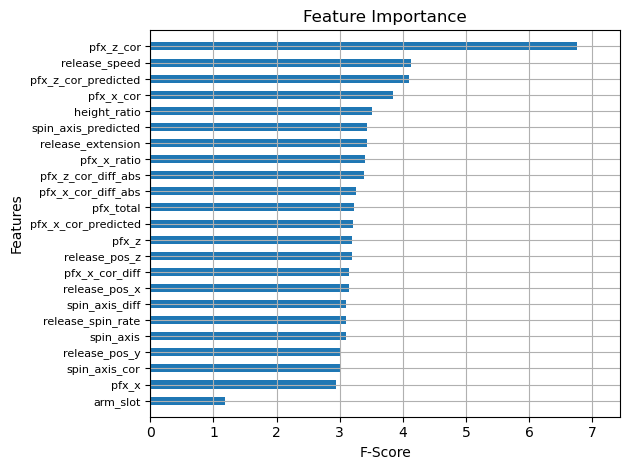

In [293]:
plt.figure(figsize=(10, 50))  # You may adjust this if needed
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)  # You can adjust fontsize if the labels are too crowded
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.savefig('feature_importance.png', dpi=300)  # Save with high resolution
plt.show()

In [294]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

pfx_z_cor: 6.762879371643066
release_speed: 4.126445293426514
pfx_z_cor_predicted: 4.098156452178955
pfx_x_cor: 3.8372347354888916
height_ratio: 3.504044532775879
spin_axis_predicted: 3.4365696907043457
release_extension: 3.432096004486084
pfx_x_ratio: 3.3997955322265625
pfx_z_cor_diff_abs: 3.387314796447754
pfx_x_cor_diff_abs: 3.2646689414978027
pfx_total: 3.218918561935425
pfx_x_cor_predicted: 3.206803321838379
pfx_z: 3.200881242752075
release_pos_z: 3.192366361618042
pfx_x_cor_diff: 3.150050401687622
release_pos_x: 3.141576051712036
spin_axis_diff: 3.1016690731048584
release_spin_rate: 3.100155830383301
spin_axis: 3.097719669342041
release_pos_y: 3.0149760246276855
spin_axis_cor: 3.003187894821167
pfx_x: 2.9491899013519287
arm_slot: 1.1814860105514526


In [295]:
# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [296]:
label_mapping = dict(zip(outcome_encoder.classes_, outcome_encoder.transform(outcome_encoder.classes_)))
print(label_mapping)

{'ball': 0, 'double': 1, 'double_play': 2, 'field_out': 3, 'foul': 4, 'home_run': 5, 'single': 6, 'strike': 7, 'strikeout': 8, 'triple': 9, 'walk': 10}


In [297]:
print(linear_weights)

    Unnamed: 0         description  linear_weight
0            0                ball       0.046350
1            1  caught_stealing_2b      -0.246377
2            2              double       0.753249
3            3         double_play      -0.773110
4            4           field_out      -0.217943
5            5                foul      -0.037243
6            6            home_run       1.368162
7            7              single       0.467429
8            8              strike      -0.052630
9            9           strikeout      -0.215231
10          10              triple       1.097815
11          11                walk       0.236323


In [ ]:
# for each outcome columns: mean rv of outcome * outcome probability
# aggregate by pitcher and pitch type
# rank

In [298]:
linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])
print(linear_weights)

    Unnamed: 0  description  linear_weight  outcome
0            0         ball       0.046350        0
2            2       double       0.753249        1
3            3  double_play      -0.773110        2
4            4    field_out      -0.217943        3
5            5         foul      -0.037243        4
6            6     home_run       1.368162        5
7            7       single       0.467429        6
8            8       strike      -0.052630        7
9            9    strikeout      -0.215231        8
10          10       triple       1.097815        9
11          11         walk       0.236323       10


In [320]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# Now perform the weighted sum
df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [356]:
grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 50)

# Group the DataFrame by 'player_name' and 'pitch_type' and sum the 'pitch_quality'
pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# Sort the results by 'pitch_quality' in descending order and take the top 10
top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# Sort the results by 'pitch_quality' in ascending order and take the bottom 10
bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# Print the top 10 and bottom 10
print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
              player_name pitch_type  pitch_quality
896           Short, Zack         FA       0.033303
208       Coulombe, Danny         SI       0.031340
619           Maile, Luke         FA       0.030648
508         Kelly, Carson         FA       0.028987
217      Criswell, Cooper         FC       0.028116
511          Kelly, Kevin         FC       0.026476
317            Fry, David         FA       0.021878
1090  Williamson, Brandon         FF       0.021131
679         Milone, Tommy         FF       0.020836
966          Suter, Brent         SI       0.020112

Bottom 10:
          player_name pitch_type  pitch_quality
1015  Valdez, Framber         FC      -0.027503
441         Hill, Tim         FF      -0.026880
70    Bautista, Félix         FF      -0.023813
206   Coulombe, Danny         FC      -0.023443
284   Fairbanks, Pete         FF      -0.022617
841     Rogers, Tyler         SI      -0.022168
624     Mantiply, Joe         SI      -0.020927
207   Coulombe, Danny   

In [362]:
max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']

mean_stuff = pitch_quality_sum['stuff_plus'].mean()

scaling_factor = 100 / mean_stuff

# Apply the scaling factor
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor

# Adjust the mean to be exactly 100
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# Now sort by the new normalized_quality column and display the results
sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)
sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1
sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)
sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(50)

,player_name,pitch_type,stuff_plus
1,"Valdez, Framber",FC,183
2,"Hill, Tim",FF,181
3,"Bautista, Félix",FF,172
4,"Coulombe, Danny",FC,171
5,"Fairbanks, Pete",FF,168
6,"Rogers, Tyler",SI,167
7,"Mantiply, Joe",SI,163
8,"Coulombe, Danny",FF,159
9,"Milner, Hoby",FF,158
10,"Sherriff, Ryan",SI,158


In [363]:
# Take the top 25 rows from your sorted DataFrame
top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# Plotting as a table and removing axis
fig, ax = plt.subplots(figsize=(6, 8))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',  # Center text in cells
                 colLoc='center')  # Center text in column headers
plt.tight_layout()

# Save the figure as a .png file to the specified path
plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\stuff_plus_v1.png', dpi=300)

plt.close()  # Close the plot to prevent it from displaying in the notebook output
